In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# https://drive.google.com/file/d/1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
!gdown --id 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 5.09MB/s]


In [4]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [96]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd. read_csv (
  dataset_path,
  names = headers,
  encoding ='ISO-8859-1'
)

In [97]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique()
                                                     .tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

## Tiền xử lý dữ liệu

In [98]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()


def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

## Xây dựng bộ từ vựng

In [99]:
vocab = []
for sentence in df['content']. tolist():
    tokens = sentence . split()
    for token in tokens:
        if token not in vocab:
            vocab . append(token)

vocab . append('UNK')
vocab . append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [100]:
def transform(text, word_to_idx, max_seq_len):

    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[: max_seq_len]

    return tokens

## Chia  bộ dữ liệu train, val, test

In [101]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## Xây dựng pytorch datasets

In [102]:
class FinancialNews (Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx

        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)

        return text, label

## Khai báo dataloader

In [103]:
max_seq_len = 32
train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## Xây dựng mô hình

In [104]:
class SentimentClassifierBiLSTM(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifierBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, n_layers,
            batch_first=True, bidirectional=True
        )
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]

        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [105]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifierBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
) .to(device)

## Loss và optimizer

In [106]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

## Training

In [107]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}: \t Train loss : {train_loss:.4f} \t Val loss : {val_loss:.4f}')

    return train_losses, val_losses

In [108]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [109]:
train_losses, val_losses = fit(
  model,
  train_loader,
  val_loader,
  criterion,
  optimizer,
  device,
  epochs
)

EPOCH 1: 	 Train loss : 1.0378 	 Val loss : 0.9897
EPOCH 2: 	 Train loss : 0.9564 	 Val loss : 0.9509
EPOCH 3: 	 Train loss : 0.9443 	 Val loss : 0.9395
EPOCH 4: 	 Train loss : 0.9282 	 Val loss : 0.9351
EPOCH 5: 	 Train loss : 0.9230 	 Val loss : 0.9324
EPOCH 6: 	 Train loss : 0.9236 	 Val loss : 0.9304
EPOCH 7: 	 Train loss : 0.9203 	 Val loss : 0.9285
EPOCH 8: 	 Train loss : 0.9136 	 Val loss : 0.9278
EPOCH 9: 	 Train loss : 0.9230 	 Val loss : 0.9269
EPOCH 10: 	 Train loss : 0.9160 	 Val loss : 0.9262
EPOCH 11: 	 Train loss : 0.9129 	 Val loss : 0.9254
EPOCH 12: 	 Train loss : 0.9081 	 Val loss : 0.9251
EPOCH 13: 	 Train loss : 0.9165 	 Val loss : 0.9248
EPOCH 14: 	 Train loss : 0.9092 	 Val loss : 0.9232
EPOCH 15: 	 Train loss : 0.9055 	 Val loss : 0.9237
EPOCH 16: 	 Train loss : 0.8992 	 Val loss : 0.9231
EPOCH 17: 	 Train loss : 0.8991 	 Val loss : 0.9236
EPOCH 18: 	 Train loss : 0.8978 	 Val loss : 0.9229
EPOCH 19: 	 Train loss : 0.8957 	 Val loss : 0.9220
EPOCH 20: 	 Train los

In [110]:
torch.save(model.state_dict(), 'Sentiment_Financial_News_BiLSTM.pth')

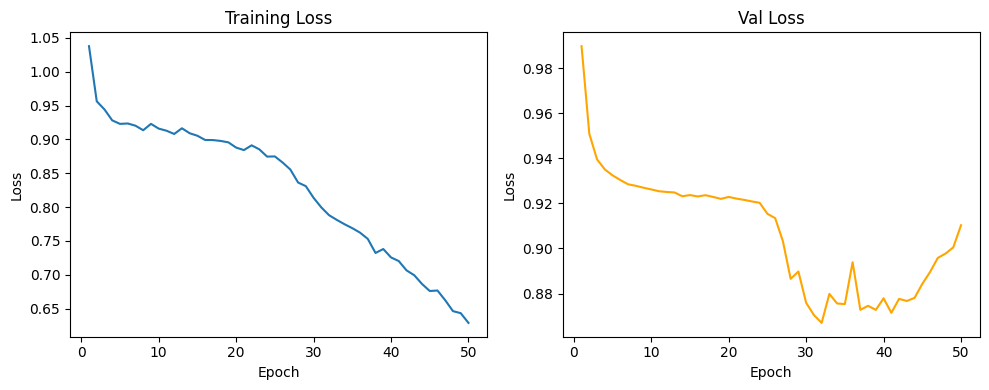

In [111]:
epochs_range = range(1, epochs + 1)

# Plotting Training and Validation Loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Training Loss
axes[0].plot(epochs_range, train_losses, color='tab:blue')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Validation Loss
axes[1].plot(epochs_range, val_losses, color='orange')
axes[1].set_title("Val Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [112]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset ')
print('Val accuracy : ', val_acc)
print('Test accuracy : ', test_acc)

Evaluation on val / test dataset 
Val accuracy :  0.6298969072164948
Test accuracy :  0.645618556701031
